Generate a temperature sensor stream with 50 Sine wave pattern based anomalies. Each pattern spans 5 points.

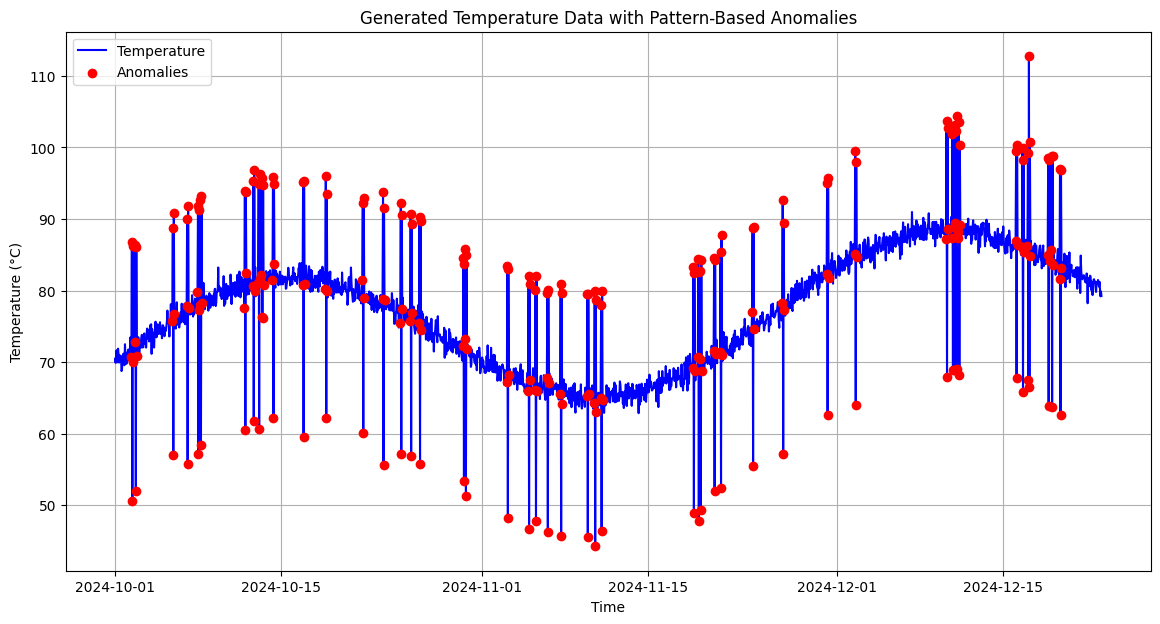

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

np.random.seed(42)

n_records = 2000
n_anomalies = 50
anomaly_pattern_length = 5

start_time = pd.Timestamp('2024-10-01 00:00:00')
timestamps = [start_time + timedelta(hours=i) for i in range(n_records)]

trend = np.linspace(0, 10, n_records)
seasonal_pattern = 10 * np.sin(np.linspace(0, 3 * np.pi, n_records))
temperature_normal = 70 + trend + seasonal_pattern + np.random.normal(0, 1, n_records)
temperature = temperature_normal.copy()

anomaly_start_indices = np.random.choice(range(n_records - anomaly_pattern_length), size=n_anomalies, replace=False)

for start_idx in anomaly_start_indices:
    anomaly_pattern = 20 * np.sin(np.linspace(0, 3 * np.pi, anomaly_pattern_length))
    temperature[start_idx:start_idx + anomaly_pattern_length] += anomaly_pattern

df = pd.DataFrame({
    'Timestamp': timestamps,
    'Temperature (°C)': temperature,
})

df.set_index('Timestamp', inplace=True)

df['Anomaly'] = 0
for start_idx in anomaly_start_indices:
    df.loc[df.index[start_idx:start_idx + anomaly_pattern_length], 'Anomaly'] = 1

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Temperature (°C)'], label='Temperature', color='blue')
plt.scatter(df.index[df['Anomaly'] == 1], df['Temperature (°C)'][df['Anomaly'] == 1],
            color='red', label='Anomalies', zorder=5)
plt.title('Generated Temperature Data with Pattern-Based Anomalies')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()


Use Random Forest to detect anomalies

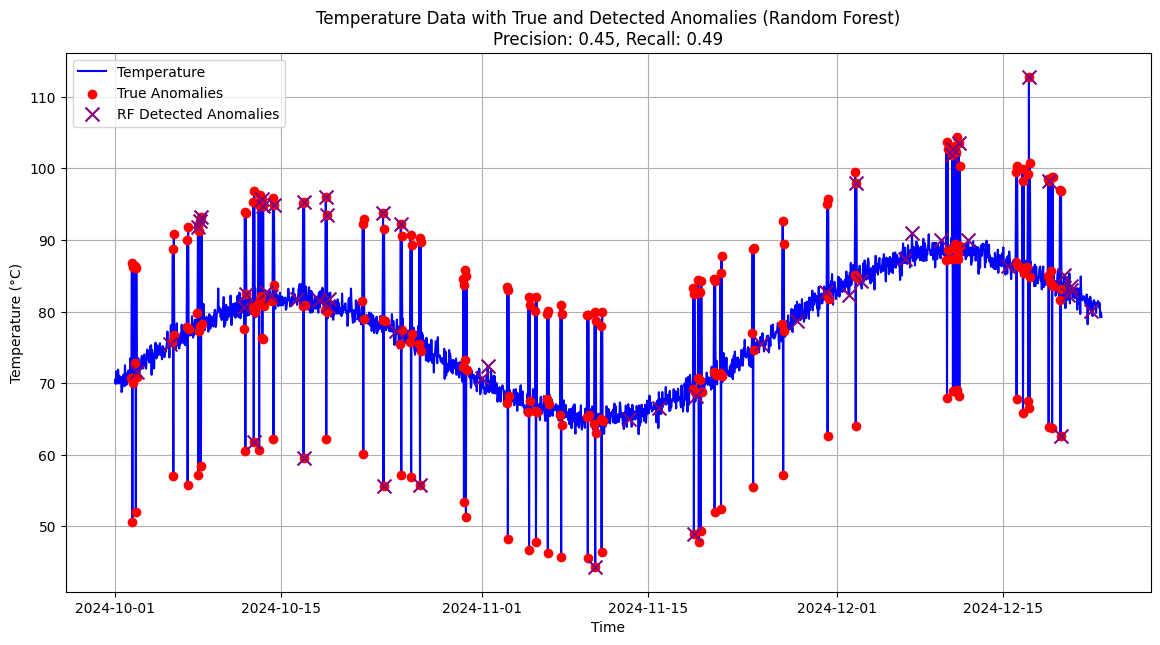

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

X = df[['Temperature (°C)']]
y = df['Anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

df_test = pd.DataFrame(X_test)
df_test['RF_Anomaly'] = y_pred

df_test['True_Anomaly'] = 0
df_test.loc[y_test.index, 'True_Anomaly'] = y_test

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Temperature (°C)'], label='Temperature', color='blue')
plt.scatter(df.index[df['Anomaly'] == 1], df['Temperature (°C)'][df['Anomaly'] == 1],
            color='red', label='True Anomalies', zorder=5)

predicted_anomalies_indices = df_test.index[df_test['RF_Anomaly'] == 1]
predicted_anomalies_values = df['Temperature (°C)'][predicted_anomalies_indices]

plt.scatter(predicted_anomalies_indices, predicted_anomalies_values,
            color='purple', label='RF Detected Anomalies', marker='x', s=100, zorder=5)

plt.title(f'Temperature Data with True and Detected Anomalies (Random Forest)\n'
          f'Precision: {precision:.2f}, Recall: {recall:.2f}')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()


In [3]:
pip install statsmodels

Let's plot ACF and PACF to figure out p and q

<Figure size 1000x500 with 0 Axes>

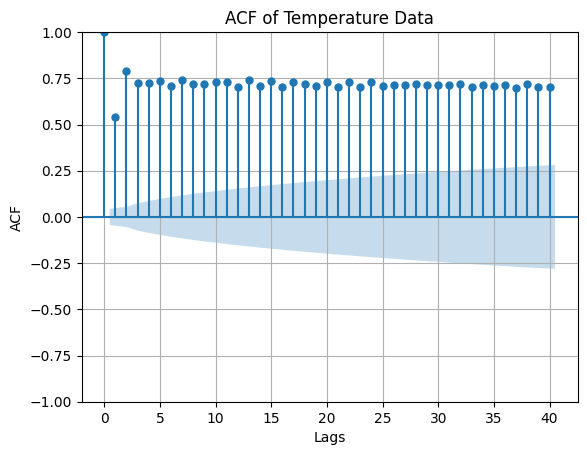

<Figure size 1000x500 with 0 Axes>

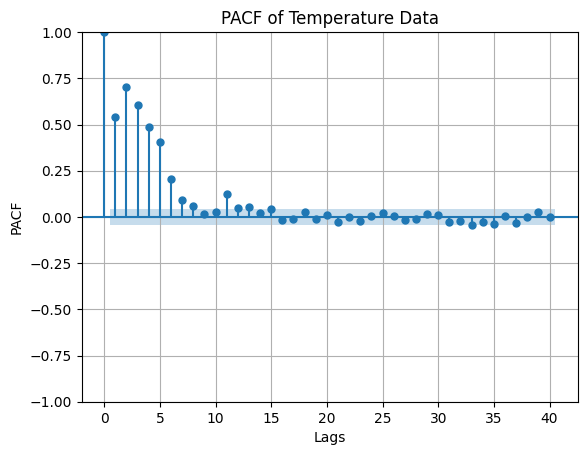

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Refresh DataFrame
df = pd.DataFrame({
    'Timestamp': timestamps,
    'Temperature (°C)': temperature,
})

df.set_index('Timestamp', inplace=True)

df['Anomaly'] = 0
for start_idx in anomaly_start_indices:
    df.loc[df.index[start_idx:start_idx + anomaly_pattern_length], 'Anomaly'] = 1

plt.figure(figsize=(10, 5))
plot_acf(df['Temperature (°C)'], lags=40)
plt.title('ACF of Temperature Data')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plot_pacf(df['Temperature (°C)'], lags=40)
plt.title('PACF of Temperature Data')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid()
plt.show()

The ACF and PACF charts show AR components with a p of 5. Now let's calculate stationarity.

In [5]:
from statsmodels.tsa.stattools import adfuller

df = pd.DataFrame({
    'Timestamp': timestamps,
    'Temperature (°C)': temperature,
})
df.set_index('Timestamp', inplace=True)

adf_result = adfuller(df['Temperature (°C)'])
p_value = adf_result[1]
if p_value < 0.05:
    print("The series is stationary")
else:
    print("The series is non-stationary")

The series is non-stationary


Considering that the series is non stationary, we need to make it stationary but using differencing of order 1. If order 1 doesn't make it stationary will have to increase the order.

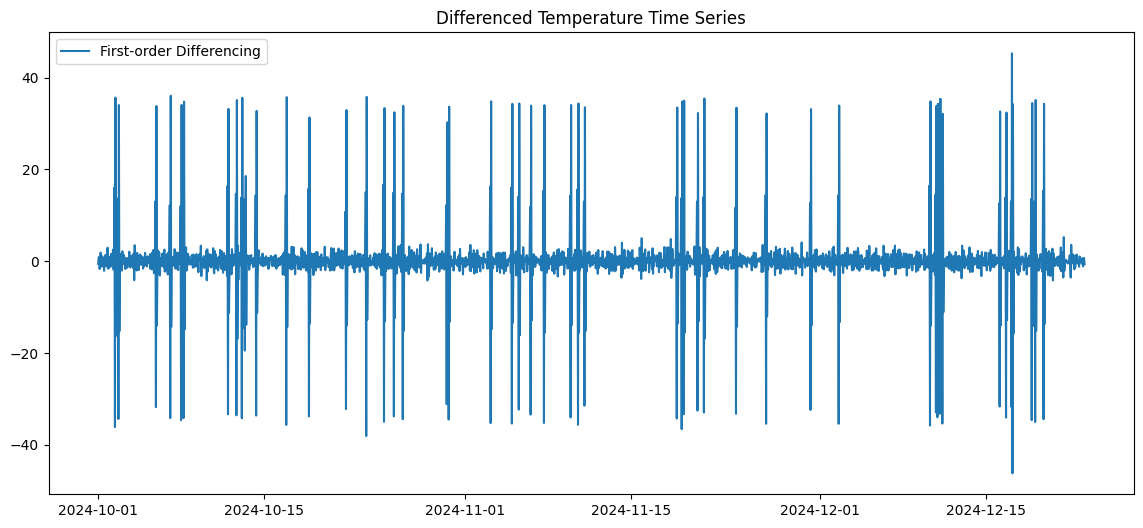

In [6]:
df['Temperature_diff1'] = df['Temperature (°C)'].diff()

plt.figure(figsize=(14, 6))
plt.plot(df['Temperature_diff1'], label='First-order Differencing')
plt.title('Differenced Temperature Time Series')
plt.legend()
plt.show()

Going with ARIMA (5, 1, 0)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


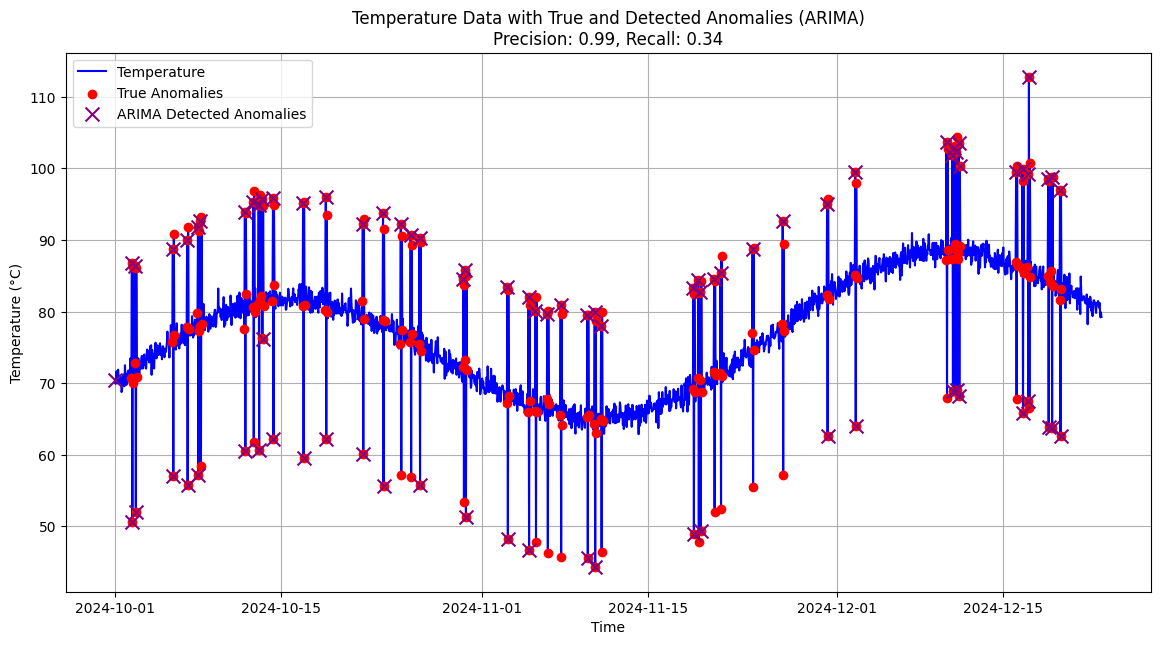

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import precision_score, recall_score

# Refresh DataFrame
df = pd.DataFrame({
    'Timestamp': timestamps,
    'Temperature (°C)': temperature,
})

df.set_index('Timestamp', inplace=True)

df['Anomaly'] = 0
for start_idx in anomaly_start_indices:
    df.loc[df.index[start_idx:start_idx + anomaly_pattern_length], 'Anomaly'] = 1

model = ARIMA(df['Temperature (°C)'], order=(5, 1, 0))
model_fit = model.fit()

predictions = model_fit.predict(start=0, end=len(df) - 1, typ='levels')
residuals = df['Temperature (°C)'] - predictions

threshold = 2 * np.std(residuals)

df['ARIMA_Anomaly'] = np.where(np.abs(residuals) > threshold, 1, 0)

precision = precision_score(df['Anomaly'], df['ARIMA_Anomaly'])
recall = recall_score(df['Anomaly'], df['ARIMA_Anomaly'])

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Temperature (°C)'], label='Temperature', color='blue')
plt.scatter(df.index[df['Anomaly'] == 1], df['Temperature (°C)'][df['Anomaly'] == 1],
            color='red', label='True Anomalies', zorder=5)

plt.scatter(df.index[df['ARIMA_Anomaly'] == 1], df['Temperature (°C)'][df['ARIMA_Anomaly'] == 1],
            color='purple', label='ARIMA Detected Anomalies', marker='x', s=100, zorder=5)

plt.title(f'Temperature Data with True and Detected Anomalies (ARIMA)\n'
          f'Precision: {precision:.2f}, Recall: {recall:.2f}')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()


Now let's use an LSTM. First we are going to refresh the dataframe because the ARIMA code might have touched it. We are then going to do some feature engineering by scaling the values and also creating sequences so that the LSTM can learn from time series sequences rather than individual values. We are then going to use a simple LSTM architecture.

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8188 - loss: 0.6546 - val_accuracy: 0.9375 - val_loss: 0.4382
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8739 - loss: 0.4466 - val_accuracy: 0.9375 - val_loss: 0.2347
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8822 - loss: 0.3713 - val_accuracy: 0.9375 - val_loss: 0.2322
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8897 - loss: 0.3607 - val_accuracy: 0.9375 - val_loss: 0.2323
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8885 - loss: 0.3555 - val_accuracy: 0.9375 - val_loss: 0.2387
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8813 - loss: 0.3704 - val_accuracy: 0.9375 - val_loss: 0.2346
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8878 - loss: 0.3577 - val_accuracy: 0.9375 - val_loss: 0.2286
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8817 - loss: 0.3529 - val_accuracy: 0.9375 - val_loss: 0.2198
Ep

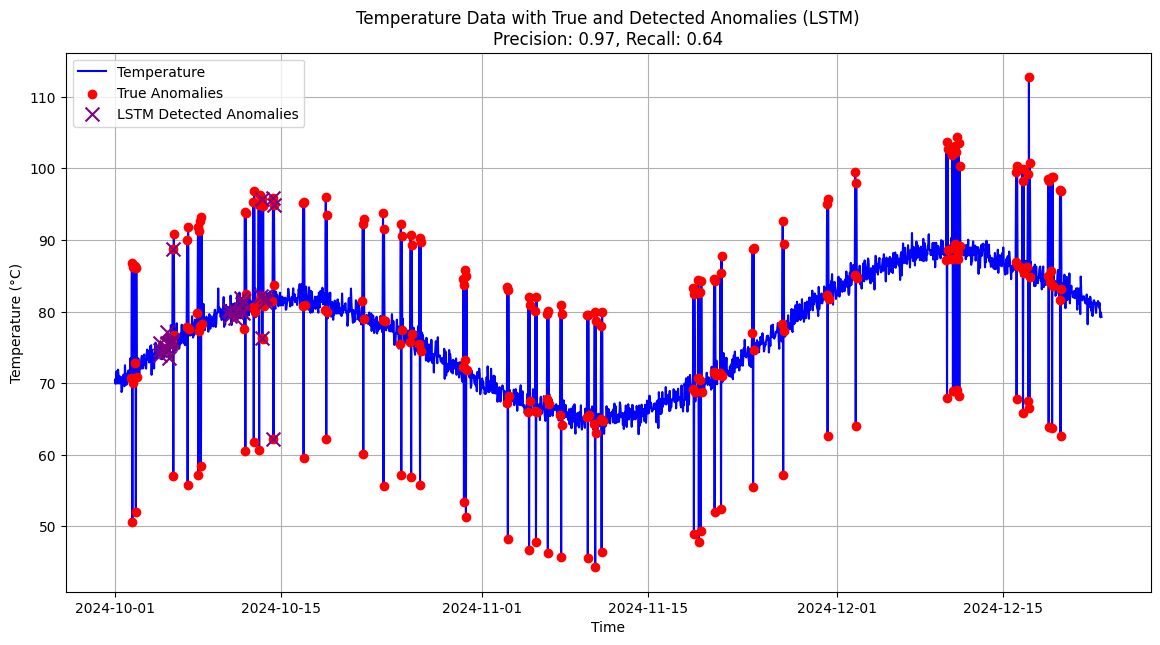

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Refresh DataFrame
df = pd.DataFrame({
    'Timestamp': timestamps,
    'Temperature (°C)': temperature,
})

df.set_index('Timestamp', inplace=True)

df['Anomaly'] = 0
for start_idx in anomaly_start_indices:
    df.loc[df.index[start_idx:start_idx + anomaly_pattern_length], 'Anomaly'] = 1

scaler = MinMaxScaler()
df['Temperature (°C)'] = scaler.fit_transform(df[['Temperature (°C)']])

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

sequence_length = 5
X = create_sequences(df['Temperature (°C)'].values, seq_length=sequence_length)

y = df['Anomaly'].values[sequence_length - 1: len(df) - 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

df['LSTM_Anomaly'] = 0
anomaly_indices = np.where(y_pred == 1)[0]
for idx in anomaly_indices:
    original_index = df.index[idx + sequence_length - 1]
    df.loc[original_index, 'LSTM_Anomaly'] = 1

plt.figure(figsize=(14, 7))
plt.plot(df.index, scaler.inverse_transform(df[['Temperature (°C)']]), label='Temperature', color='blue')
plt.scatter(df.index[df['Anomaly'] == 1], scaler.inverse_transform(df[['Temperature (°C)']][df['Anomaly'] == 1]),
            color='red', label='True Anomalies', zorder=5)

plt.scatter(df.index[df['LSTM_Anomaly'] == 1], scaler.inverse_transform(df[['Temperature (°C)']][df['LSTM_Anomaly'] == 1]),
            color='purple', label='LSTM Detected Anomalies', marker='x', s=100, zorder=5)

plt.title(f'Temperature Data with True and Detected Anomalies (LSTM)\n'
          f'Precision: {precision:.2f}, Recall: {recall:.2f}')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

